# Plotting notebook for demonstrating reproduced results
In this notebook, all results of the reproduced experiments will be shown. All results shown in this notebook were created by running their respective experiment notebooks.
Experiment plots include:
- Measuring performance on vanilla strategic classification
- Measuring performance on time-series
- Measuring performance on financial datasets
- Monitoring accuracy while regularizing for social burden
- Monitoring accuracy while regularizing for utility
- Monitoring accuracy while regularizing for recourse

In [10]:
%matplotlib notebook
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIG_SIZE = 14

# *Evaluating socially-aware performance*
Traditionally, strategic classification is only focused on optimizing performance, which can result in socially unfavourable situations in real life. To combat this issue, the authors proposed regularizing the models based three metrics: social burden, utility and recourse. Regularization was applied to the learning objective of the model according to the equation shown per metric. During the experiment, the amount of regularization was varied and the accuracy was monitored.

## Social burden VS accuracy
Social burden can be defined as the minimum cost a positively-labeled user must incur to be classified correctly.

$R_{burden} = \sum \min c(x,x')$

<IPython.core.display.Javascript object>


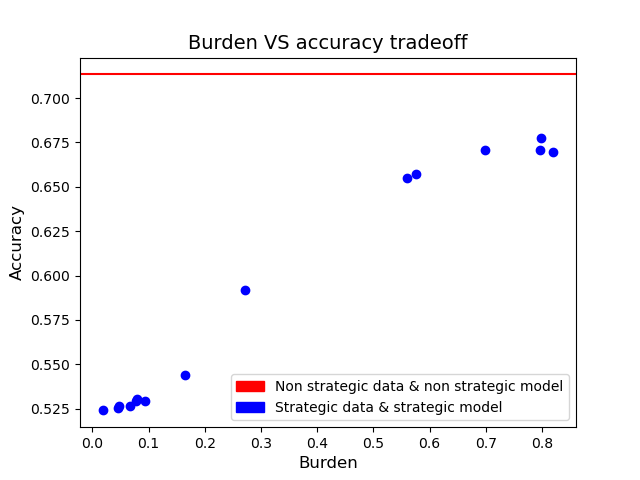

In [39]:
# Path to original burden model
# path = "./models/FINAL/burden/tradeoff"
# Path to reproduced model
path = "./models/burden"

burdens = []
accuracies = []
lambdas = []

for root,d_names,f_names in os.walk(path):
    if "val_burdens.csv" in f_names:
        lamb = root.split("/")[-1].split("_")[-1]
        lambdas.append(lamb)
        val_burdens = pd.read_csv(root + '/val_burdens.csv')
        burden = val_burdens.values[-1][1]
        burdens.append(burden)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)

fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Burden VS accuracy tradeoff')
plt.xlabel('Burden')
plt.ylabel('Accuracy')
plt.scatter(burdens, accuracies, color='b')
plt.axhline(y=0.7133, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

## Utility VS accuracy
Utility can be defined as the social good/utility gained by modifying their features.

$R_{utility} = -\sum^m_{i=1} h(\Delta(x)) - c(x,\Delta(x)) $

<IPython.core.display.Javascript object>


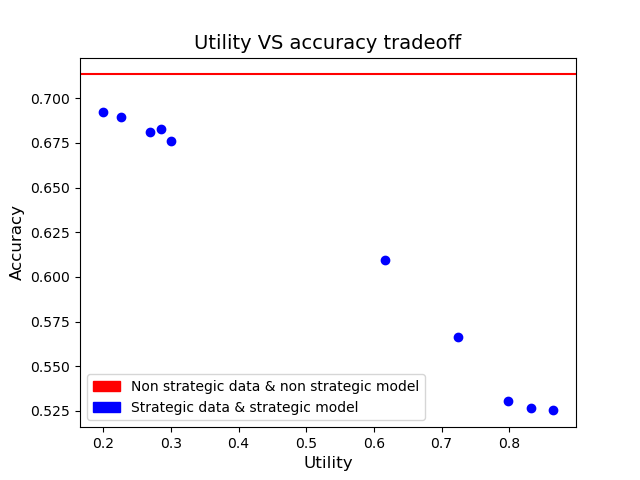

In [16]:
# Path to original utility model
# path = "./models/FINAL/utility/tradeoff"
# Path to reproduced model
path = "./models/utility"

utilities = []
accuracies = []
lambdas = []

for root,d_names,f_names in os.walk(path):
    if "val_utilities.csv" in f_names:
        lamb = root.split("/")[-1].split("_")[-1]
        lambdas.append(lamb)
        val_utilities = pd.read_csv(root + '/val_utilities.csv')
        utility = val_utilities.values[-1][1]
        utilities.append(utility)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)
        
fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Utility VS accuracy tradeoff')
plt.xlabel('Utility')
plt.ylabel('Accuracy')
plt.scatter(utilities, accuracies, color='b')
plt.axhline(y=0.7133, linestyle='-', color='r')
red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

## Recourse VS accuracy
Recourse can be defined as the capacity of a user who is denied a service to restore approval through reasonable
action.

$ R_{recourse} = \sum^m_{i=1}\sigma(-f(x)) * \sigma(-f(\Delta_f(x)))$

<IPython.core.display.Javascript object>


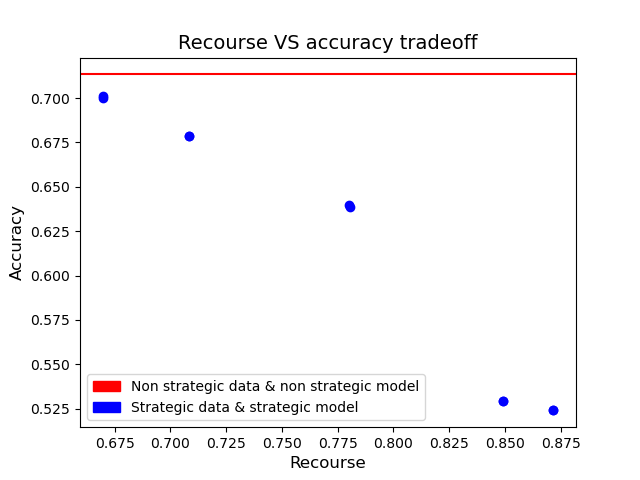

In [18]:
# Path to original recourse model
# path = "./models/FINAL/recourse/tradeoff"
# Path to reproduced recourse model
path = "./models/recourse"

recourses = []
accuracies = []
lambdas = []

for root,d_names,f_names in os.walk(path):
    if "val_recourses.csv" in f_names:
        lamb = root.split("/")[-1].split("_")[-1]
        lambdas.append(lamb)
        val_recourses = pd.read_csv(root + '/val_recourses.csv')
        recourse = val_recourses.values[-1][1]
        recourses.append(recourse)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)


fig = plt.figure()
plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Recourse VS accuracy tradeoff')
plt.xlabel('Recourse')
plt.ylabel('Accuracy')
plt.scatter(recourses, accuracies, color='b')
plt.axhline(y=0.7133, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

# *Examining model performance in different environments*

## Vanilla I
This is the situation as proposed in the original proposal of strategic classification by Hardt et al. The model is a linear classifier trained on the SERM objective, performance is measured.

<IPython.core.display.Javascript object>


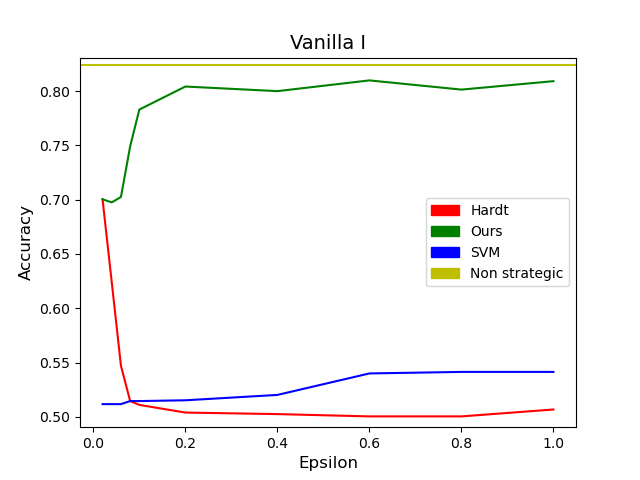

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [75]:
path = "./models/FINAL/vanilla_I/vanilla_vs_hardt_final_mid_scale0"

non_strategic_acc = 0.8239 # sklearn accuracy
epsilons = []
hardt_acc = []
ours_acc = []
svm_acc = []

for root,d_names,f_names in os.walk(path):
    if "results.csv" in f_names:
        details = root.split("\\")
        epsilon = float(details[-1])
        acc = pd.read_csv(root + '/results.csv')
        acc = acc.values[:, 1]
        epsilons.append(epsilon)
        hardt_acc.append(acc[1])
        ours_acc.append(acc[2])
        svm_acc.append(acc[3])

        
fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Vanilla I')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.plot(epsilons, hardt_acc, color='r')
ax.plot(epsilons, ours_acc, color='g')
ax.plot(epsilons, svm_acc, color='b')

plt.axhline(y=non_strategic_acc, linestyle='-', color='y')

red_patch = mpatches.Patch(color='r', label='Hardt')
green_patch = mpatches.Patch(color='g', label='Ours')
blue_patch = mpatches.Patch(color='b', label='SVM')
yellow_patch = mpatches.Patch(color='y', label='Non strategic')

plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.show()
        

[0.78473858 0.79957607 0.80970325 0.81300047 0.81700424 0.81771079
 0.82124352 0.82265662 0.8238342  0.8193594  0.81158738]


<IPython.core.display.Javascript object>


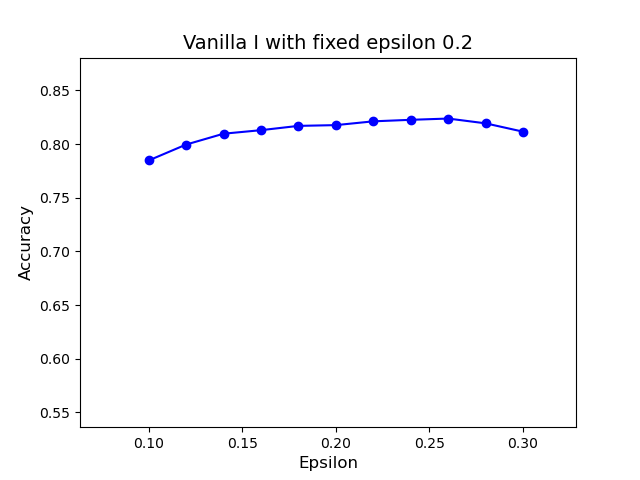

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [48]:
path = "./models/FINAL/vanilla_I/vanilla_vs_hardt_final_mid_scale0"

epsilons = pd.read_csv(path + '/fixed_train_eps_train_set/0.2/epsilons.csv').values[:, 1]
# fixed_test_acc = pd.read_csv(path + '/fixed_test_eps/0.2/accuracies.csv').values[:, 1]
fixed_train_acc = pd.read_csv(path + '/fixed_train_eps_train_set/0.2/accuracies.csv').values[:, 1]


fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Vanilla I with fixed epsilon 0.2')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
# ax.plot(epsilons, fixed_test_acc, color='r')
ax.plot(epsilons, fixed_train_acc, color='b', marker='o')

# red_patch = mpatches.Patch(color='r', label='fixed test epsilon')
# blue_patch = mpatches.Patch(color='b', label='fixed train epsilon')

# plt.legend(handles=[red_patch, blue_patch])

# plt.savefig(path + '/vanilla_vs_hardt.pdf', format='pdf')
# plt.savefig(path + '/vanilla_vs_hardt.eps', format='eps')
# plt.savefig(path + '/vanilla_vs_hardt.png', format='png')
plt.show()

<IPython.core.display.Javascript object>


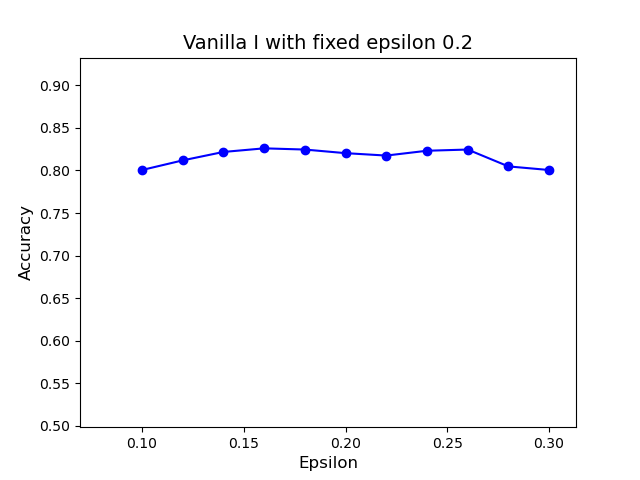

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [53]:
path = "./models/FINAL/vanilla_I/vanilla_vs_hardt_final_mid_scale0/fixed_train_eps"

epsilons = pd.read_csv(path + '/0/0.2/epsilons.csv').values[:, 1]

all_accuracies = np.zeros(len(epsilons))
i = 0
for root,d_names,f_names in os.walk(path):
    if "accuracies.csv" in f_names:
        details = root.split("\\")
        fixed_train_acc = pd.read_csv(root + '/accuracies.csv').values[:, 1]

        all_accuracies += fixed_train_acc
        i += 1

all_accuracies /= i

fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Vanilla I with fixed epsilon 0.2')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.plot(epsilons, fixed_train_acc, color='b', marker='o')


plt.show()

# Vanilla II

<IPython.core.display.Javascript object>


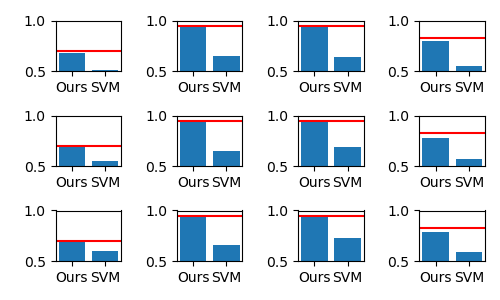

credit 0.7133333333333333
credit 0.7133333333333333
credit 0.7133333333333333
distress 0.9345238095238096
distress 0.9345238095238096
distress 0.9345238095238096
fraud 0.9319727891156462
fraud 0.9319727891156462
fraud 0.9319727891156462
spam 0.8239104829210836
spam 0.8239104829210836
spam 0.8239104829210836


In [59]:
path = "./models/FINAL/vanilla_II"
all_results = dict()
splits = 6

svm_accuracies = pd.read_csv(path + '/svm_accuracies.csv').values[:, 1]

for root,d_names,f_names in os.walk(path):
    if "results.csv" in f_names:
        details = root.split("\\")
        scale = details[-1]
        dataset = details[-3]
        acc = pd.read_csv(root + '/results.csv')
        acc = acc.values[:, 1]
        if (scale, dataset) not in all_results:
            all_results[(scale, dataset)] = np.zeros(3)
        all_results[(scale, dataset)] += acc

for key in all_results:
    all_results[key] /= splits

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(5, 3))

for i, (scale, dataset) in enumerate(all_results):
    row = i % 3
    col = i // 3
    axes[row, col].bar(["Ours", "SVM"], all_results[(scale, dataset)][1:])
    axes[row, col].set_ylim(0.5, 1) 
    axes[row, col].axhline(y=svm_accuracies[col], linestyle='-', color='r')
    
fig.tight_layout()

plt.show()

# RNN
This plot shows performance on time-series data which required an RNN to be able to use. Methods of training and evaluation were the same as previous experiments.

<IPython.core.display.Javascript object>


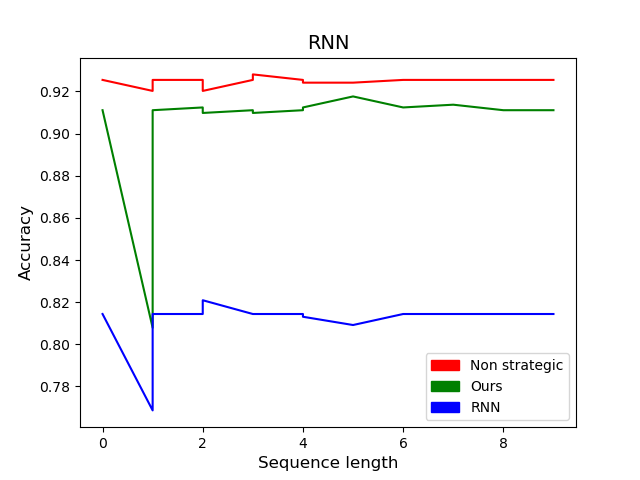

In [40]:
l = 14
num_of_splits = 9
avg_non_strategic_acc = np.zeros(l)
avg_ours_acc = np.zeros(l)
avg_rnn_acc = np.zeros(l)

for i in range(1, num_of_splits + 1):

    path = "./models/FINAL/rnn/rnn___" + str(i)

    lengths = []
    non_strategic_acc = []
    ours_acc = []
    rnn_acc = []

    for root,d_names,f_names in os.walk(path):
        if "results.csv" in f_names:
            details = root.split("\\")
            seq_len = int(details[-1][-1])
            acc = pd.read_csv(root + '/results.csv')
            acc = acc.values[:, 1]
            lengths.append(seq_len)
            non_strategic_acc.append(acc[0])
            ours_acc.append(acc[1])
            rnn_acc.append(acc[2])

    lengths = np.array(lengths)
    p = lengths.argsort()
    lengths = lengths[p]
    non_strategic_acc = np.array(non_strategic_acc)[p]
    ours_acc = np.array(ours_acc)[p]
    rnn_acc = np.array(rnn_acc)[p]


    avg_non_strategic_acc += non_strategic_acc[:l]
    avg_ours_acc += ours_acc[:l]
    avg_rnn_acc += rnn_acc[:l]


avg_non_strategic_acc /= num_of_splits
avg_ours_acc /= num_of_splits
avg_rnn_acc /= num_of_splits

fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('RNN')
plt.xlabel('Sequence length')
plt.ylabel('Accuracy')
plt.plot(lengths[:l], avg_non_strategic_acc, color='r')
plt.plot(lengths[:l], avg_ours_acc, color='g')
plt.plot(lengths[:l], avg_rnn_acc, color='b')

red_patch = mpatches.Patch(color='r', label='Non strategic')
green_patch = mpatches.Patch(color='g', label='Ours')
blue_patch = mpatches.Patch(color='b', label='RNN')

plt.legend(handles=[red_patch, green_patch, blue_patch])
plt.show()

<IPython.core.display.Javascript object>


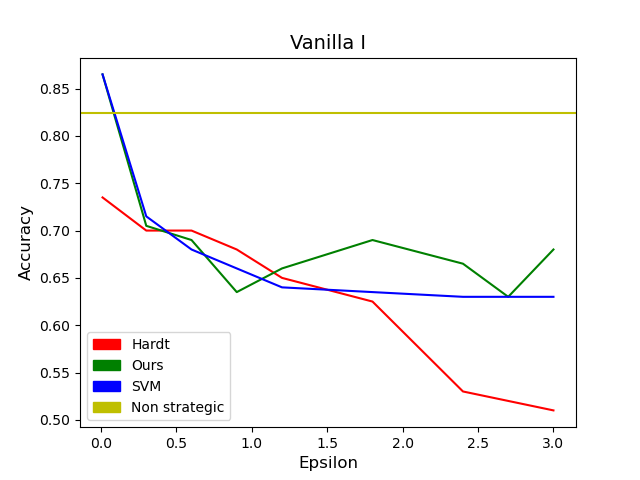

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [24]:
path = "./models/hardt/lr1_split_1"

non_strategic_acc = 0.8239 # sklearn accuracy
gaming_list = []
hardt_acc = []
ours_acc = []
svm_acc = []

for root,d_names,f_names in os.walk(path):
    if "results.csv" in f_names:
        details = root.split("\\")
        t = float(details[-1])
        acc = pd.read_csv(root + '/results.csv')
        acc = acc.values[:, 1]
        gaming_list.append(t)
        hardt_acc.append(acc[1])
        ours_acc.append(acc[2])
        svm_acc.append(acc[3])

        
fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Vanilla I')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.plot(gaming_list, hardt_acc, color='r')
ax.plot(gaming_list, ours_acc, color='g')
ax.plot(gaming_list, svm_acc, color='b')

plt.axhline(y=non_strategic_acc, linestyle='-', color='y')

red_patch = mpatches.Patch(color='r', label='Hardt')
green_patch = mpatches.Patch(color='g', label='Ours')
blue_patch = mpatches.Patch(color='b', label='SVM')
yellow_patch = mpatches.Patch(color='y', label='Non strategic')

plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])

# plt.savefig(path + '/vanilla_vs_hardt.pdf', format='pdf')
# plt.savefig(path + '/vanilla_vs_hardt.eps', format='eps')
# plt.savefig(path + '/vanilla_vs_hardt.png', format='png')
plt.show()

# Hardt x

<IPython.core.display.Javascript object>


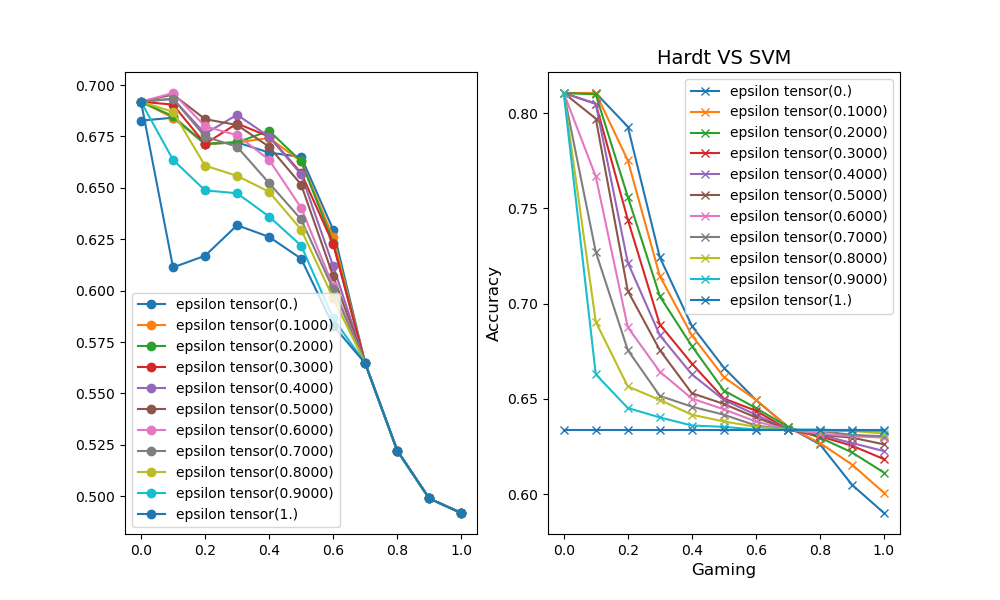

In [18]:
path = "./models/hardt/experiment2"

epsilons = torch.arange(0, 1.1, 0.1)
gaming_list = torch.arange(0, 3.1, 3/10)
gaming_list[0] = 0.01

hardt_accuracies = pd.read_csv(path + '/strategic_accuracies.csv').values[:, 1:]
svm_accuracies = pd.read_csv(path + '/non_strategic_accuracies.csv').values[:, 1:]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Hardt VS SVM')
plt.xlabel('Gaming')
plt.ylabel('Accuracy')

for i in range(len(epsilons)):
    eps, hardt_acc, svm_acc = epsilons[i], hardt_accuracies[i], svm_accuracies[i]
    axes[0].plot(epsilons, hardt_acc, marker="o", label='epsilon '+str(eps))
    axes[1].plot(epsilons, svm_acc, marker="x", label='epsilon '+str(eps))
    
axes[0].legend()
axes[1].legend()

# plt.savefig(path + '/vanilla_vs_hardt.pdf', format='pdf')
# plt.savefig(path + '/vanilla_vs_hardt.eps', format='eps')
# plt.savefig(path + '/vanilla_vs_hardt.png', format='png')
plt.show()

<IPython.core.display.Javascript object>


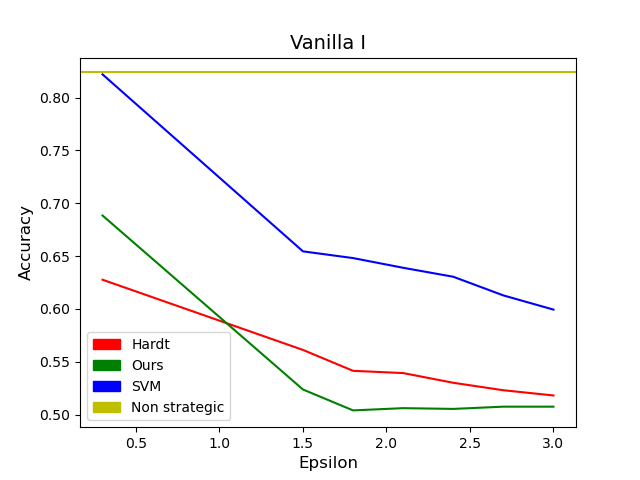

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [43]:
path = "./models/hardt/split_4/0.01"

non_strategic_acc = 0.8239 # sklearn accuracy
gaming_list = []
hardt_acc = []
ours_acc = []
svm_acc = []

for root,d_names,f_names in os.walk(path):
    if "results.csv" in f_names:
        details = root.split("\\")
        t = float(details[-1])
        acc = pd.read_csv(root + '/results.csv')
        acc = acc.values[:, 1]
        gaming_list.append(t)
        hardt_acc.append(acc[1])
        ours_acc.append(acc[2])
        svm_acc.append(acc[3])

        
fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Vanilla I')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.plot(gaming_list, hardt_acc, color='r')
ax.plot(gaming_list, ours_acc, color='g')
ax.plot(gaming_list, svm_acc, color='b')

plt.axhline(y=non_strategic_acc, linestyle='-', color='y')

red_patch = mpatches.Patch(color='r', label='Hardt')
green_patch = mpatches.Patch(color='g', label='Ours')
blue_patch = mpatches.Patch(color='b', label='SVM')
yellow_patch = mpatches.Patch(color='y', label='Non strategic')

plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])

# plt.savefig(path + '/vanilla_vs_hardt.pdf', format='pdf')
# plt.savefig(path + '/vanilla_vs_hardt.eps', format='eps')
# plt.savefig(path + '/vanilla_vs_hardt.png', format='png')
plt.show()